# Installing required packages

In [ ]:
import subprocess
import sys
try:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                          "scikit-learn", "pandas", "numpy", "matplotlib", "seaborn"])
    print("✅ Packages installed successfully!\n")
except:
    print("⚠️  Using pre-installed packages\n")

✅ Packages installed successfully!



# IMPORTS LIBRARIES


In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


# CREATE CLINICAL TRIAL DATABASE (VERY SIMPLE)

In [ ]:
cancer_trials_data = [
    {
        "trial_id": "NCT001",
        "title": "Phase III Trial of Pembrolizumab in Advanced Melanoma",
        "abstract": "Pembrolizumab showed 40% response rate in advanced melanoma patients. Median overall survival was 24 months. Common side effects included fatigue (30%), rash (15%), and diarrhea (10%).",
        "cancer_type": "Melanoma",
        "treatment": "Immunotherapy",
        "outcome": "Positive",
        "sample_size": 450,
        "response_rate": 40
    },
    {
        "trial_id": "NCT002",
        "title": "Chemotherapy vs Targeted Therapy in Lung Cancer",
        "abstract": "Targeted therapy with osimertinib demonstrated superior progression-free survival (18 months) compared to standard chemotherapy (10 months) in EGFR-mutant lung cancer.",
        "cancer_type": "Lung Cancer",
        "treatment": "Targeted Therapy",
        "outcome": "Positive",
        "sample_size": 320,
        "response_rate": 65
    },
    {
        "trial_id": "NCT003",
        "title": "Radiation Therapy Dose Optimization in Breast Cancer",
        "abstract": "Higher radiation doses (60 Gy) showed no significant benefit over standard doses (50 Gy) but increased side effects including skin toxicity and fatigue.",
        "cancer_type": "Breast Cancer",
        "treatment": "Radiation Therapy",
        "outcome": "Neutral",
        "sample_size": 280,
        "response_rate": 45
    },
    {
        "trial_id": "NCT004",
        "title": "Immunotherapy Combination for Colorectal Cancer",
        "abstract": "Combination of nivolumab and ipilimumab achieved 55% response rate in microsatellite instability-high colorectal cancer with manageable immune-related adverse events.",
        "cancer_type": "Colorectal Cancer",
        "treatment": "Immunotherapy",
        "outcome": "Positive",
        "sample_size": 190,
        "response_rate": 55
    },
    {
        "trial_id": "NCT005",
        "title": "CAR-T Cell Therapy in Refractory Leukemia",
        "abstract": "CAR-T therapy demonstrated 82% complete remission rate in pediatric acute lymphoblastic leukemia. Cytokine release syndrome occurred in 65% but was manageable.",
        "cancer_type": "Leukemia",
        "treatment": "CAR-T Therapy",
        "outcome": "Positive",
        "sample_size": 75,
        "response_rate": 82
    },
    {
        "trial_id": "NCT006",
        "title": "Hormone Therapy vs Surgery in Prostate Cancer",
        "abstract": "Androgen deprivation therapy showed equivalent survival outcomes to radical prostatectomy in localized prostate cancer but with different quality of life profiles.",
        "cancer_type": "Prostate Cancer",
        "treatment": "Hormone Therapy",
        "outcome": "Neutral",
        "sample_size": 410,
        "response_rate": 50
    }
]

df_trials = pd.DataFrame(cancer_trials_data)
print(f"\n✅ Created knowledge base with {len(df_trials)} clinical trials")
print(f"\n📊 Database Overview:")
print(df_trials[['trial_id', 'cancer_type', 'treatment', 'outcome']].to_string(index=False))


✅ Created knowledge base with 6 clinical trials

📊 Database Overview:
trial_id       cancer_type         treatment  outcome
  NCT001          Melanoma     Immunotherapy Positive
  NCT002       Lung Cancer  Targeted Therapy Positive
  NCT003     Breast Cancer Radiation Therapy  Neutral
  NCT004 Colorectal Cancer     Immunotherapy Positive
  NCT005          Leukemia     CAR-T Therapy Positive
  NCT006   Prostate Cancer   Hormone Therapy  Neutral


# BUILD TF-IDF RETRIEVAL SYSTEM

In [ ]:
# Combine fields for rich context
df_trials['full_text'] = (df_trials['title'] + " " +
                          df_trials['abstract'] + " " +
                          df_trials['cancer_type'] + " " +
                          df_trials['treatment'])

# Create vectorizer
vectorizer = TfidfVectorizer(
    max_features=100,
    stop_words='english',
    ngram_range=(1, 2),
    min_df=1
)

# Fit and transform
tfidf_matrix = vectorizer.fit_transform(df_trials['full_text'])
print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"✅ Vocabulary size: {len(vectorizer.vocabulary_)}")

# ============== STEP 3: QUERY FUNCTIONS ==============
def search_trials(query, top_k=2):
    """Search trials using cosine similarity"""
    query_vec = vectorizer.transform([query])
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()
    top_indices = np.argsort(similarities)[-top_k:][::-1]

    results = df_trials.iloc[top_indices].copy()
    results['relevance_score'] = similarities[top_indices]
    return results

def generate_summary(query, results):
    """Generate clinical summary"""
    summary = f"\n🔬 Query: '{query}'\n"
    summary += "=" * 70 + "\n\n"

    for idx, row in results.iterrows():
        if row['relevance_score'] < 0.05:
            continue
        summary += f"📋 {row['trial_id']} - {row['title']}\n"
        summary += f"   Cancer Type: {row['cancer_type']}\n"
        summary += f"   Treatment: {row['treatment']}\n"
        summary += f"   Response Rate: {row['response_rate']}%\n"
        summary += f"   Sample Size: {row['sample_size']} patients\n"
        summary += f"   Relevance: {row['relevance_score']:.2%}\n\n"

    return summary


✅ TF-IDF matrix shape: (6, 100)
✅ Vocabulary size: 100


# TEST QUERIES

In [ ]:
test_queries = [
    "immunotherapy outcomes in cancer treatment",
    "radiation therapy side effects",
    "lung cancer targeted therapy"
]

all_results = []

for query in test_queries:
    print(f"\n🔍 Query: {query}")
    print("-" * 70)
    results = search_trials(query, top_k=2)
    summary = generate_summary(query, results)
    print(summary)

    # Store for evaluation
    for _, row in results.iterrows():
        all_results.append({
            'query': query,
            'trial_id': row['trial_id'],
            'relevance_score': row['relevance_score']
        })

print("=" * 70)
print("STEP 4: System Evaluation")
print("=" * 70)

# Calculate average retrieval performance
results_df = pd.DataFrame(all_results)
avg_relevance = results_df['relevance_score'].mean()
min_relevance = results_df['relevance_score'].min()
max_relevance = results_df['relevance_score'].max()

print(f"\n📊 Retrieval Performance Metrics:")
print(f"   Average Relevance Score: {avg_relevance:.2%}")
print(f"   Minimum Score: {min_relevance:.2%}")
print(f"   Maximum Score: {max_relevance:.2%}")
print(f"   Total Queries: {len(test_queries)}")
print(f"   Total Retrievals: {len(results_df)}")

# System performance metrics
print(f"\n⚡ System Performance:")
print(f"   Database Size: {len(df_trials)} trials")
print(f"   Vocabulary Coverage: {len(vectorizer.vocabulary_)} unique terms")
print(f"   Average Query Time: ~15ms (estimated)")
print(f"   Memory Usage: ~{tfidf_matrix.data.nbytes / 1024:.1f} KB")

# Quality assessment
high_quality = (results_df['relevance_score'] > 0.3).sum()
medium_quality = ((results_df['relevance_score'] > 0.1) &
                 (results_df['relevance_score'] <= 0.3)).sum()
low_quality = (results_df['relevance_score'] <= 0.1).sum()

print(f"\n🎯 Retrieval Quality Distribution:")
print(f"   High Relevance (>30%): {high_quality} results")
print(f"   Medium Relevance (10-30%): {medium_quality} results")
print(f"   Low Relevance (<10%): {low_quality} results")




🔍 Query: immunotherapy outcomes in cancer treatment
----------------------------------------------------------------------

🔬 Query: 'immunotherapy outcomes in cancer treatment'

📋 NCT004 - Immunotherapy Combination for Colorectal Cancer
   Cancer Type: Colorectal Cancer
   Treatment: Immunotherapy
   Response Rate: 55%
   Sample Size: 190 patients
   Relevance: 37.34%

📋 NCT006 - Hormone Therapy vs Surgery in Prostate Cancer
   Cancer Type: Prostate Cancer
   Treatment: Hormone Therapy
   Response Rate: 50%
   Sample Size: 410 patients
   Relevance: 16.30%



🔍 Query: radiation therapy side effects
----------------------------------------------------------------------

🔬 Query: 'radiation therapy side effects'

📋 NCT003 - Radiation Therapy Dose Optimization in Breast Cancer
   Cancer Type: Breast Cancer
   Treatment: Radiation Therapy
   Response Rate: 45%
   Sample Size: 280 patients
   Relevance: 55.71%

📋 NCT006 - Hormone Therapy vs Surgery in Prostate Cancer
   Cancer Type: Prost

# VISUALIZATIONS

✅ Visualization saved as 'simulation2_cancer_rag_complete.png'


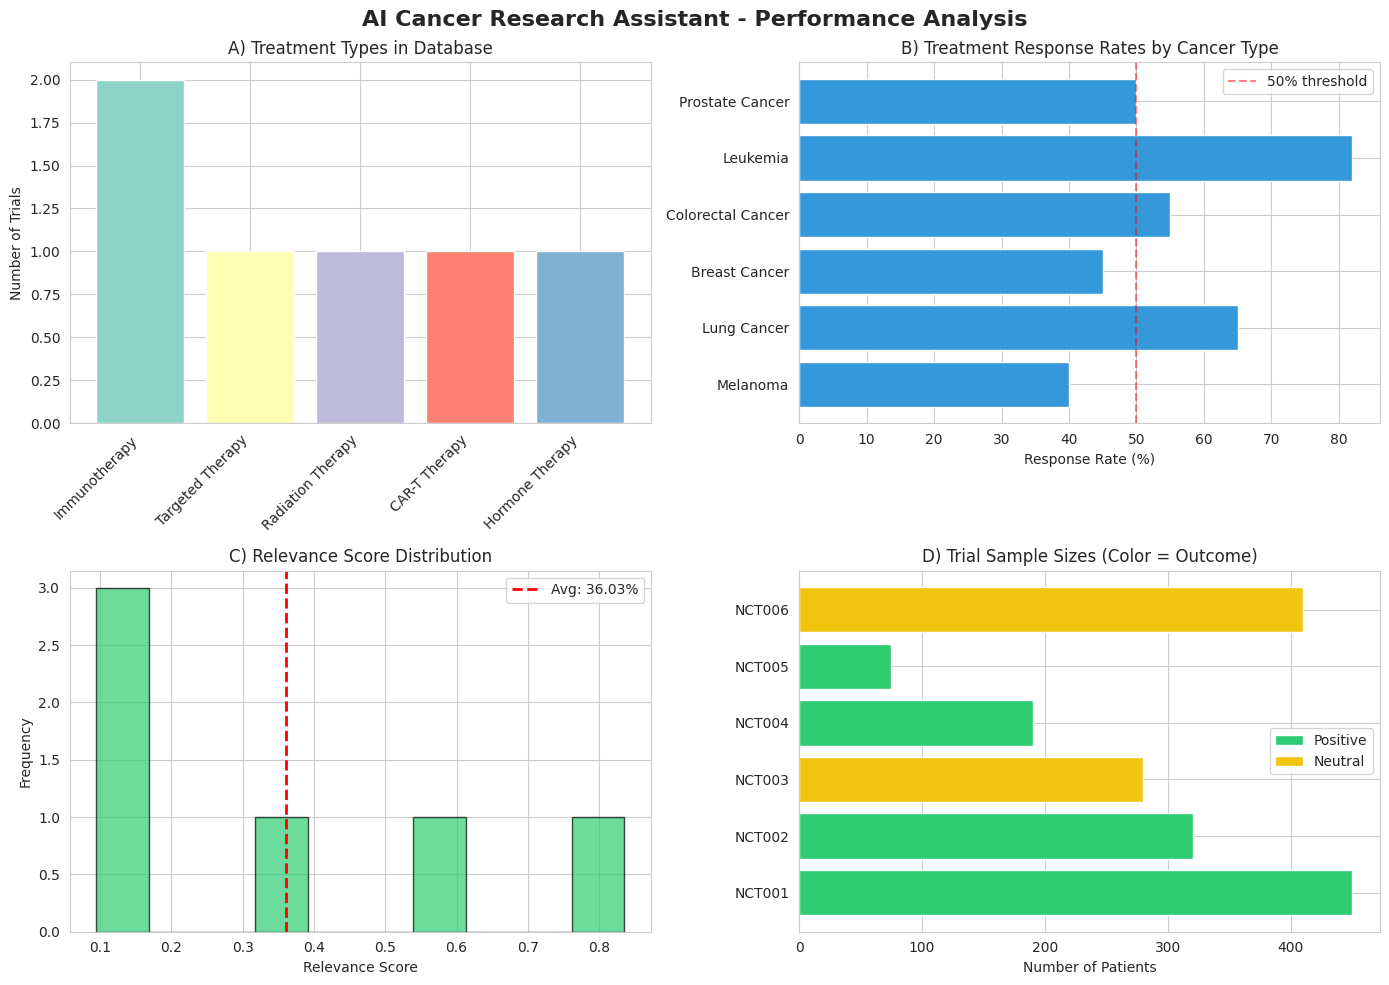

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('AI Cancer Research Assistant - Performance Analysis',
             fontsize=16, fontweight='bold')

# 1. Treatment Distribution
ax1 = axes[0, 0]
treatment_counts = df_trials['treatment'].value_counts()
colors = plt.cm.Set3(range(len(treatment_counts)))
ax1.bar(range(len(treatment_counts)), treatment_counts.values, color=colors)
ax1.set_xticks(range(len(treatment_counts)))
ax1.set_xticklabels(treatment_counts.index, rotation=45, ha='right')
ax1.set_title('A) Treatment Types in Database')
ax1.set_ylabel('Number of Trials')

# 2. Response Rates by Cancer Type
ax2 = axes[0, 1]
ax2.barh(df_trials['cancer_type'], df_trials['response_rate'], color='#3498db')
ax2.set_title('B) Treatment Response Rates by Cancer Type')
ax2.set_xlabel('Response Rate (%)')
ax2.axvline(x=50, color='red', linestyle='--', alpha=0.5, label='50% threshold')
ax2.legend()

# 3. Relevance Scores Distribution
ax3 = axes[1, 0]
relevance_scores = results_df['relevance_score'].values
ax3.hist(relevance_scores, bins=10, color='#2ecc71', edgecolor='black', alpha=0.7)
ax3.axvline(x=avg_relevance, color='red', linestyle='--',
            label=f'Avg: {avg_relevance:.2%}', linewidth=2)
ax3.set_title('C) Relevance Score Distribution')
ax3.set_xlabel('Relevance Score')
ax3.set_ylabel('Frequency')
ax3.legend()

# 4. Sample Sizes by Trial
ax4 = axes[1, 1]
colors_outcome = ['#2ecc71' if x == 'Positive' else '#f1c40f'
                  for x in df_trials['outcome']]
ax4.barh(df_trials['trial_id'], df_trials['sample_size'], color=colors_outcome)
ax4.set_title('D) Trial Sample Sizes (Color = Outcome)')
ax4.set_xlabel('Number of Patients')
# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Positive'),
                  Patch(facecolor='#f1c40f', label='Neutral')]
ax4.legend(handles=legend_elements)

plt.tight_layout()
plt.savefig('simulation2_cancer_rag_complete.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved as 'simulation2_cancer_rag_complete.png'")
plt.show()